In [1]:
# Load some useful modules 
import numpy as np
import xarray as xr
import xrft
import zarr
from xmitgcm import llcreader
from matplotlib import pyplot as plt
import cmocean.cm as cm
import gcm_filters

%matplotlib inline

In [2]:
from intake import open_catalog

cat = open_catalog("https://raw.githubusercontent.com/pangeo-data/pangeo-datastore/master/intake-catalogs/ocean/llc4320.yaml")

In [3]:
# Get variables from catalog
sst = cat.LLC4320_SST.to_dask()
ssh = cat.LLC4320_SSH.to_dask()

/srv/conda/envs/notebook/lib/python3.11/site-packages/intake_xarray/base.py:21: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  'dims': dict(self._ds.dims),
/srv/conda/envs/notebook/lib/python3.11/site-packages/intake_xarray/base.py:21: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  'dims': dict(self._ds.dims),


In [4]:
ds = xr.merge([sst,ssh])
ds = llcreader.llcmodel.faces_dataset_to_latlon(ds, metric_vector_pairs=[])

coords = cat.LLC4320_grid.to_dask().reset_coords()
coords = llcreader.llcmodel.faces_dataset_to_latlon(coords)
# Get data on a single face 
ds_face = xr.merge([ssh.sel(face=1), sst.sel(face=1)])

# Get coordiantes from the catalog
coords_face = (cat.LLC4320_grid.to_dask()).sel(face=1)

/srv/conda/envs/notebook/lib/python3.11/site-packages/xmitgcm/llcreader/llcmodel.py:322: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  data = np.arange(ifac * coords.dims[vname])
/srv/conda/envs/notebook/lib/python3.11/site-packages/xmitgcm/llcreader/llcmodel.py:324: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  data = np.arange(jfac * coords.dims[vname])
/srv/conda/envs/notebook/lib/python3.11/site-packages/intake_xarray/base.py:21: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.

In [5]:
filter = gcm_filters.Filter(
    filter_scale=16,
    dx_min=1,
    filter_shape=gcm_filters.FilterShape.GAUSSIAN,
    grid_type=gcm_filters.GridType.REGULAR,
    grid_vars={}
)

In [6]:
ds_in_1 = ds.Eta.isel(time=slice(0,9030,120)).isel(i=slice(12000,13280), j=slice(6000,7280))

In [ ]:
ds_in_1.plot()

In [27]:
user_path = "gs://leap-persistent/funky-user"  # 👀 make sure to prepend `gs://` to the path or xarray will interpret this as a local path
store_name = "ds_in_1.zarr"
ds_in_1.to_zarr(f"{user_path}/{store_name}")

In [7]:
ds_in_2 = ds.Eta.isel(time=slice(0,9030,120)).isel(i=slice(0,1280), j=slice(4000,5280))

In [32]:
user_path = "gs://leap-persistent/funky-user"  # 👀 make sure to prepend `gs://` to the path or xarray will interpret this as a local path
store_name = "ds_in_2.zarr"
ds_in_2.chunk({"time":1, "i":-1, "j":-1}).to_zarr(f"{user_path}/{store_name}")

In [8]:
mask1 = (~np.isnan(ds_in_1)).astype('float32')
mask2 = (~np.isnan(ds_in_2)).astype('float32')

In [9]:
filter_masked1 = gcm_filters.Filter(
    filter_scale=16,
    dx_min=1,
    filter_shape=gcm_filters.FilterShape.GAUSSIAN,
    grid_type=gcm_filters.GridType.REGULAR_WITH_LAND,
    grid_vars={'wet_mask': mask1.chunk({'i':-1,'j':-1})}
)

In [10]:
filter_masked2 = gcm_filters.Filter(
    filter_scale=16,
    dx_min=1,
    filter_shape=gcm_filters.FilterShape.GAUSSIAN,
    grid_type=gcm_filters.GridType.REGULAR_WITH_LAND,
    grid_vars={'wet_mask': mask2.chunk({'i':-1,'j':-1})}
)

In [11]:
%time ds_in_1_filtered = filter.apply(ds_in_1.chunk({'i':-1,'j':-1}), dims=['j','i'])

CPU times: user 4.3 ms, sys: 28 μs, total: 4.33 ms
Wall time: 4.28 ms


In [12]:
%time ds_in_2_filtered = filter.apply(ds_in_2.chunk({'i':-1,'j':-1}), dims=['j','i'])

CPU times: user 3.41 ms, sys: 36 μs, total: 3.44 ms
Wall time: 3.41 ms


In [19]:
ds_in_1_filtered.compute()

<xarray.DataArray 'Eta' (time: 76, j: 1280, i: 1280)> Size: 498MB
array([[[0.73068637, 0.6915697 , 0.6551247 , ..., 0.8465923 ,
         0.8100367 , 0.7708533 ],
        [0.64993733, 0.6123326 , 0.57730794, ..., 0.76141393,
         0.72625   , 0.6885656 ],
        [0.57464695, 0.53844696, 0.5047441 , ..., 0.68201494,
         0.6481409 , 0.6118469 ],
        ...,
        [0.9692552 , 0.9257493 , 0.88518333, ..., 1.0980408 ,
         1.057434  , 1.0138922 ],
        [0.89415085, 0.85200435, 0.8127149 , ..., 1.0189412 ,
         0.9795919 , 0.9374017 ],
        [0.8134991 , 0.77284086, 0.7349481 , ..., 0.93392044,
         0.8959456 , 0.85523343]],

       [[0.61298096, 0.593972  , 0.5761735 , ..., 0.6681797 ,
         0.651009  , 0.632338  ],
        [0.5780114 , 0.5574363 , 0.53820884, ..., 0.63795036,
         0.6192751 , 0.59899724],
        [0.5455765 , 0.52354944, 0.50299364, ..., 0.609903  ,
         0.58983546, 0.5680709 ],
...
        [1.2427896 , 1.1740252 , 1.1097906 , ..., 1.4455683 ,
         1.3817594 , 1.3132097 ],
        [1.1623024 , 1.0946367 , 1.031458  , ..., 1.3619695 ,
         1.2991215 , 1.2316244 ],
        [1.0758574 , 1.0094137 , 0.947416  , ..., 1.272139  ,
         1.2103215 , 1.1439697 ]],

       [[0.6706363 , 0.6817196 , 0.6923051 , ..., 0.63866675,
         0.648676  , 0.6594592 ],
        [0.6507892 , 0.6613173 , 0.6713722 , ..., 0.62048113,
         0.6299527 , 0.6401772 ],
        [0.63243663, 0.6424861 , 0.6520798 , ..., 0.60354364,
         0.6125596 , 0.62230855],
        ...,
        [0.73047024, 0.74345404, 0.75581956, ..., 0.69270647,
         0.7046001 , 0.7173353 ],
        [0.71138495, 0.72372335, 0.7354913 , ..., 0.6756113 ,
         0.68685585, 0.6989202 ],
        [0.69117   , 0.7028658 , 0.7140316 , ..., 0.6573529 ,
         0.66796154, 0.67936647]]], dtype=float32)
Coordinates:
  * i        (i) int64 10kB 12000 12001 12002 12003 ... 13276 13277 13278 13279
  * j        (j) int64 10kB 6000 6001 6002 6003 6004 ... 7276 7277 7278 7279
  * time     (time) datetime64[ns] 608B 2011-09-13 2011-09-18 ... 2012-09-22

In [27]:
import xarray as xr

ds = xr.open_dataset(
    "gs://leap-persistent/funky-user/ds_in_2_filtered.zarr", engine="zarr", chunks={}
)  #

In [28]:
ds

<xarray.Dataset> Size: 498MB
Dimensions:  (time: 76, j: 1280, i: 1280)
Coordinates:
  * i        (i) int64 10kB 0 1 2 3 4 5 6 ... 1273 1274 1275 1276 1277 1278 1279
  * j        (j) int64 10kB 4000 4001 4002 4003 4004 ... 5276 5277 5278 5279
  * time     (time) datetime64[ns] 608B 2011-09-13 2011-09-18 ... 2012-09-22
Data variables:
    Eta      (time, j, i) float32 498MB dask.array<chunksize=(1, 1280, 1280), meta=np.ndarray>

In [21]:
user_path = "gs://leap-persistent/funky-user"  # 👀 make sure to prepend `gs://` to the path or xarray will interpret this as a local path
store_name = "ds_in_1_filtered.zarr"
ds_in_1_filtered.to_zarr(f"{user_path}/{store_name}")

In [21]:
ds_in_2_filtered.compute()

<xarray.DataArray 'Eta' (time: 76, j: 1280, i: 1280)> Size: 498MB
array([[[-1.3238728 , -1.3402846 , -1.354288  , ..., -1.2713374 ,
         -1.2881961 , -1.3060621 ],
        [-1.5150597 , -1.5309078 , -1.544263  , ..., -1.4641199 ,
         -1.4804189 , -1.49777   ],
        [-1.6915991 , -1.7069138 , -1.7196714 , ..., -1.6422156 ,
         -1.6579678 , -1.6748155 ],
        ...,
        [-0.75196296, -0.76975614, -0.7854425 , ..., -0.6957562 ,
         -0.7139106 , -0.7329588 ],
        [-0.93286407, -0.95029646, -0.96552014, ..., -0.87756693,
         -0.89539754, -0.9141536 ],
        [-1.1263304 , -1.143289  , -1.1579357 , ..., -1.0722948 ,
         -1.0896802 , -1.1080296 ]],

       [[-1.1175146 , -1.0900404 , -1.064729  , ..., -1.2009001 ,
         -1.1742687 , -1.1460718 ],
        [-1.2449049 , -1.217594  , -1.1924394 , ..., -1.3279126 ,
         -1.3013805 , -1.2733107 ],
        [-1.3629668 , -1.3356274 , -1.3104306 , ..., -1.4460447 ,
         -1.4194893 , -1.391395  ],
...
        [-0.36549047, -0.3654555 , -0.3659248 , ..., -0.36855236,
         -0.367086  , -0.36606735],
        [-0.50597066, -0.5017136 , -0.49832898, ..., -0.52200425,
         -0.51635635, -0.51094866],
        [-0.65745234, -0.64848953, -0.6408023 , ..., -0.68789184,
         -0.6776118 , -0.6673263 ]],

       [[-1.1165687 , -1.0764579 , -1.0389655 , ..., -1.2360703 ,
         -1.1981515 , -1.157788  ],
        [-1.2802999 , -1.2426124 , -1.2073685 , ..., -1.3930387 ,
         -1.3571324 , -1.3190651 ],
        [-1.4301827 , -1.3950845 , -1.3622651 , ..., -1.5357516 ,
         -1.5019783 , -1.4663446 ],
        ...,
        [-0.62133497, -0.57526433, -0.53237987, ..., -0.7580122 ,
         -0.7148967 , -0.6686926 ],
        [-0.77867264, -0.7343593 , -0.6930384 , ..., -0.9101711 ,
         -0.86864173, -0.8242004 ],
        [-0.9462788 , -0.9039529 , -0.86442775, ..., -1.0720425 ,
         -1.0322481 , -0.9897572 ]]], dtype=float32)
Coordinates:
  * i        (i) int64 10kB 0 1 2 3 4 5 6 ... 1273 1274 1275 1276 1277 1278 1279
  * j        (j) int64 10kB 4000 4001 4002 4003 4004 ... 5276 5277 5278 5279
  * time     (time) datetime64[ns] 608B 2011-09-13 2011-09-18 ... 2012-09-22

In [22]:
user_path = "gs://leap-persistent/funky-user"  # 👀 make sure to prepend `gs://` to the path or xarray will interpret this as a local path
store_name = "ds_in_2_filtered.zarr"
ds_in_2_filtered.to_zarr(f"{user_path}/{store_name}")

In [20]:
%time ds_in_1_filtered_masked = filter_masked1.apply(ds_in_1.chunk({'i':-1,'j':-1}), dims=['j','i'])

CPU times: user 4.02 ms, sys: 0 ns, total: 4.02 ms
Wall time: 3.92 ms


In [22]:
%time ds_in_2_filtered_masked = filter_masked2.apply(ds_in_2.chunk({'i':-1,'j':-1}), dims=['j','i'])

CPU times: user 4.8 ms, sys: 0 ns, total: 4.8 ms
Wall time: 4.55 ms


In [23]:
smaller_datasets1_unfiltered = []
smaller_datasets1_filtered = []


original_i_size1 = ds_in_1.to_dataset().dims['i']
original_j_size1 = ds_in_1.to_dataset().dims['j']

# Iterate over the entire dataset to create smaller subsets
for i_start in range(0, original_i_size1, 128):
    for j_start in range(0, original_j_size1, 128):
        # Calculate the end indices for slicing
        i_end = min(i_start + 128, original_i_size1)  # Ensure i_end does not exceed 13279
        j_end = min(j_start + 128, original_j_size1)   # Ensure j_end does not exceed 7279

        
        # Subset the dataset
        ds_filtered_subset1 = ds_in_1_filtered_masked.isel(time=slice(0,76), i=slice(i_start, i_end, 4), j=slice(j_start, j_end, 4))
        ds_unfiltered_subset1 = ds_in_1.isel(time=slice(0,76), i=slice(i_start, i_end, 4), j=slice(j_start, j_end, 4))
        
        # Append the subsets to the respective lists
        smaller_datasets1_filtered.append(ds_filtered_subset1)
        smaller_datasets1_unfiltered.append(ds_unfiltered_subset1)


/tmp/ipykernel_1212/3221785111.py:5: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  original_i_size1 = ds_in_1.to_dataset().dims['i']
/tmp/ipykernel_1212/3221785111.py:6: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  original_j_size1 = ds_in_1.to_dataset().dims['j']


In [24]:
smaller_datasets2_unfiltered = []
smaller_datasets2_filtered = []

original_i_size2 = ds_in_2.to_dataset().dims['i']
original_j_size2 = ds_in_2.to_dataset().dims['j']

# Iterate over the entire dataset to create smaller subsets
for i_start in range(0, original_i_size2, 128):
    for j_start in range(0, original_j_size2, 128):
        # Calculate the end indices for slicing
        i_end = min(i_start + 128, original_i_size2)  # Ensure i_end does not exceed 13279
        j_end = min(j_start + 128, original_j_size2)   # Ensure j_end does not exceed 7279

        # Subset the dataset
        ds_unfiltered_subset2 = ds_in_2.isel(time=slice(0,76), i=slice(i_start, i_end, 4), j=slice(j_start, j_end, 4))
        ds_filtered_subset2 = ds_in_2_filtered_masked.isel(time=slice(0,76), i=slice(i_start, i_end, 4), j=slice(j_start, j_end, 4))
        
        # Append the subsets to the respective lists
        smaller_datasets2_unfiltered.append(ds_unfiltered_subset2)
        smaller_datasets2_filtered.append(ds_filtered_subset2)

/tmp/ipykernel_1212/123321186.py:4: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  original_i_size2 = ds_in_2.to_dataset().dims['i']
/tmp/ipykernel_1212/123321186.py:5: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  original_j_size2 = ds_in_2.to_dataset().dims['j']


In [25]:
ds1_filtered = xr.concat(smaller_datasets1_filtered, dim='dataset', data_vars='all', coords='minimal')
ds1_unfiltered = xr.concat(smaller_datasets1_unfiltered, dim='dataset', data_vars='all', coords='minimal')

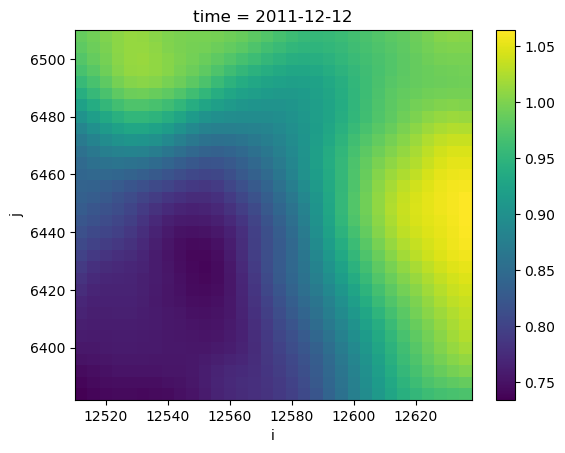

In [52]:
smaller_datasets1_filtered[43].isel(time=18).plot(cmap='viridis')

plt.savefig('filtered_dataset.png')


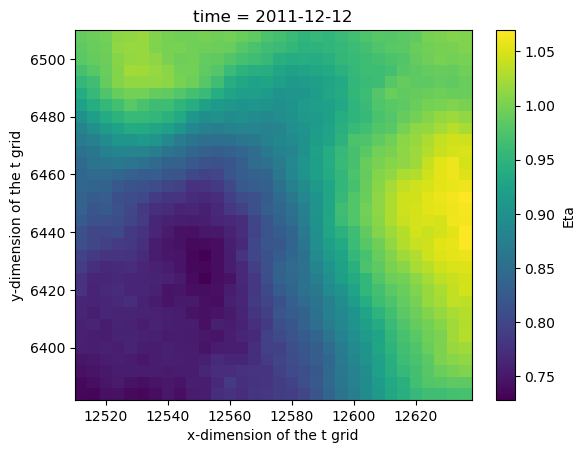

In [27]:
smaller_datasets1_unfiltered[43].isel(time=18).plot()

plt.savefig('unfiltered_dataset.png')

In [30]:
import xarray as xr

ds1_filtered = xr.open_dataset(
    "gs://leap-persistent/funky-user/ds1_filtered.zarr", engine="zarr", chunks={}
)  


In [31]:
ds1_unfiltered = xr.open_dataset(
    "gs://leap-persistent/funky-user/ds1_unfiltered.zarr", engine="zarr", chunks={}
)  


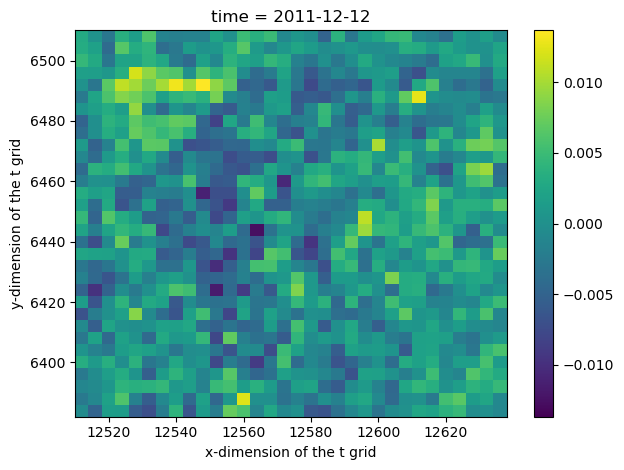

In [50]:
(smaller_datasets1_unfiltered[43] - smaller_datasets1_filtered[43]).isel(time=18).plot(cmap='viridis')


plt.tight_layout()
plt.savefig('SSH_anomaly.png', bbox_inches='tight') 